In [1]:
import numpy as np
import scipy as cp
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
def load_data(file, sep='\s+'):
    return pd.read_csv(file, sep=sep)


def sample_data(data, train_frac):
    copy = data.copy()
    copy.reindex(np.random.permutation(copy.index))
    train_count = train_frac * copy.shape[0]
    # yield training set attrs and labels
    yield copy.ix[:train_count,:-1].as_matrix()
    yield copy.ix[:train_count,-1].as_matrix()
    # yield validation set attrs and labels
    yield copy.ix[train_count:,:-1].as_matrix()
    yield copy.ix[train_count:,-1].as_matrix()

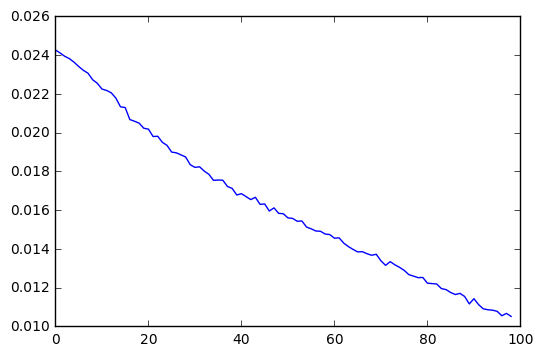

In [8]:
def create_means(num_basis, dim=4):
    return np.random.uniform(-1.0, 1.0, (num_basis, dim))


def gauss_basis(x, mu):
    t = x - mu
    return np.exp(-t.dot(t)**2)


def regression(design, y, lamb):
    lambI = lamb * np.identity(design.shape[1])
    w1 = lambI + design.T.dot(design)
    w2 = np.linalg.inv(w1).dot(design.T)
    return w2.dot(y)


def learn(x, y, lamb, basis, num_basis):
    means = create_means(num_basis)
    num_attrs = num_basis + 1
    design = np.empty([x.shape[0], num_attrs])
    for i in range(design.shape[0]):
        design[i, 0] = 1.0
        for j in range(1, design.shape[1]):
            design[i, j] = basis(x[i], means[j-1])
    return means, regression(design, y, lamb)


def predict(w, basis, means, num_basis, x):
    num_attrs = num_basis + 1
    ret = w[0]
    for i in range(1, w.shape[0]):
        ret += w[i] * basis(x, means[i-1])
    return ret


def rms_error(y_predicted, y_real):
    err = 0
    for p, r in zip(y_predicted, y_real):
        err += (p - r)**2
    return np.sqrt(err) / y_real.shape[0]


def training(ntimes, data, basis, num_basis, train_frac=0.6667, lamb=0.0):
    rms_err = 0.0
    for i in range(ntimes):
        xt, yt, xv, yv = sample_data(data, train_frac)
        mu, w = learn(xt, yt, lamb, basis, num_basis)
        y_predict = []
        for x in xt:
            y_predict.append(predict(w, basis, mu, num_basis, x))
        rms_err += rms_error(y_predict, yt)
    return rms_err / ntimes



def train_basis_number(ntimes, data, basis, train_frac=0.6667, lamb=0.0):
    m_err = []
    for m in range(1, 100):
        m_err.append(training(ntimes, data, basis, m, train_frac, lamb))
    return np.array(m_err)



err = train_basis_number(100, load_data('dataset.txt'), gauss_basis)
plt.plot(err, 'b-')
plt.show()

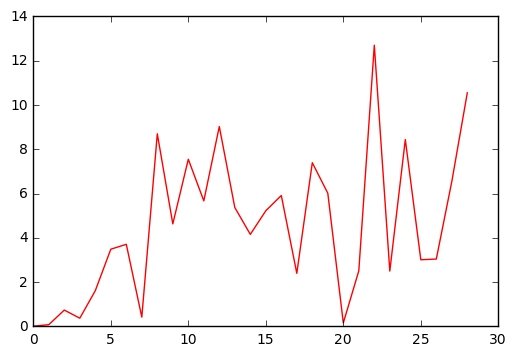

In [6]:
def train_basis_number(ntimes, data, basis, train_frac=0.6667, lamb=0.0):
    m_err = []
    for m in range(1, 50):
        m_err.append(training(ntimes, data, basis, m, train_frac, lamb))
    return np.array(m_err)

err = train_basis_number(100, load_data('dataset.txt'), gauss_basis)
plt.plot(err, 'b-')
plt.show()

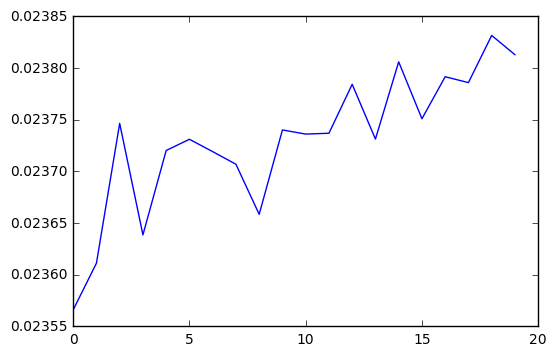

In [7]:
def train_regularization_factor(ntimes, data, basis, train_frac=0.6667, m=5):
    m_err = []
    lambdas = [l for l in np.arange(0.0, 1.0, 0.05)]
    for l in lambdas:
        m_err.append(training(ntimes, data, basis, m, train_frac, l))
    return np.array(m_err)

err = train_regularization_factor(100, load_data('dataset.txt'), gauss_basis)
plt.plot(err, 'b-')
plt.show()